# Проект по моделям машинного обучения с учителем (supervised learning) - Методы на основе деревьев
------

## ЦЕЛЬ: Создать модель предсказания того, уйдёт ли абонент в отток (churn).

----
----


## Часть 0: Импортируем библиотеки и загружаем данные

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Часть 1: Общие характеристики данных

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [58]:
df.describe(include='number').transpose()


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


# Часть 2:  Исследование данных (Exploratory Data Analysis)

## Исследование признаков

In [59]:
# Отсутствующие значения
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='count'>

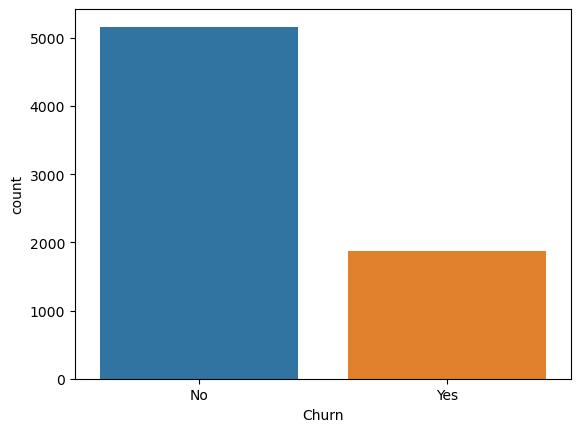

In [60]:
# Сбалансированность колонки с классами
sns.countplot(data=df, x='Churn')


<AxesSubplot:xlabel='Churn', ylabel='TotalCharges'>

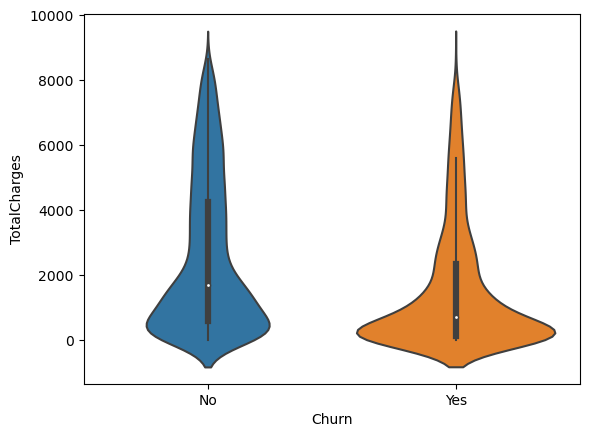

In [61]:
# Распределение колонки TotalCharges по различным категориям Churn
sns.violinplot(data=df, x='Churn', y='TotalCharges')

<AxesSubplot:xlabel='Churn', ylabel='TotalCharges'>

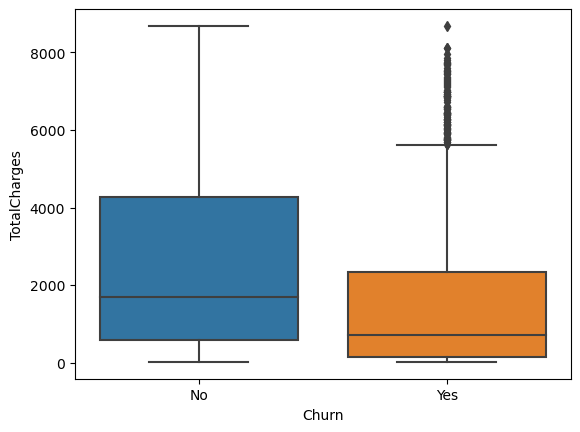

In [62]:
sns.boxplot(data=df, x='Churn', y='TotalCharges')

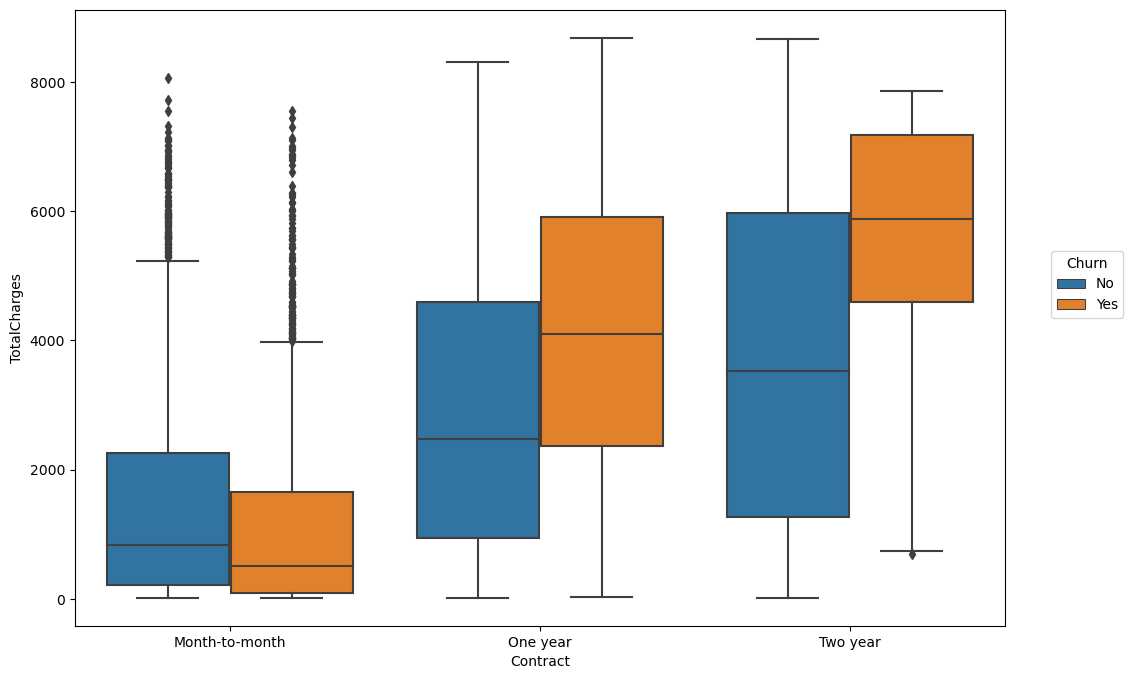

In [63]:
# Распределение колонки TotalCharges для различных типов контрактов
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Contract', y='TotalCharges', hue='Churn')
plt.legend(loc=(1.05, 0.5), title="Churn")



In [64]:
# Преобразование в дамми-переменные
df_corr = pd.get_dummies(data=df, 
               columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'])

In [65]:
# Корреляции признаков с целевой переменной
df_corr['is_Churn'] = df_corr['Churn'].map({'No': 0, 'Yes': 1})
df_corr = df_corr.corr()['is_Churn'].drop('is_Churn').sort_values()

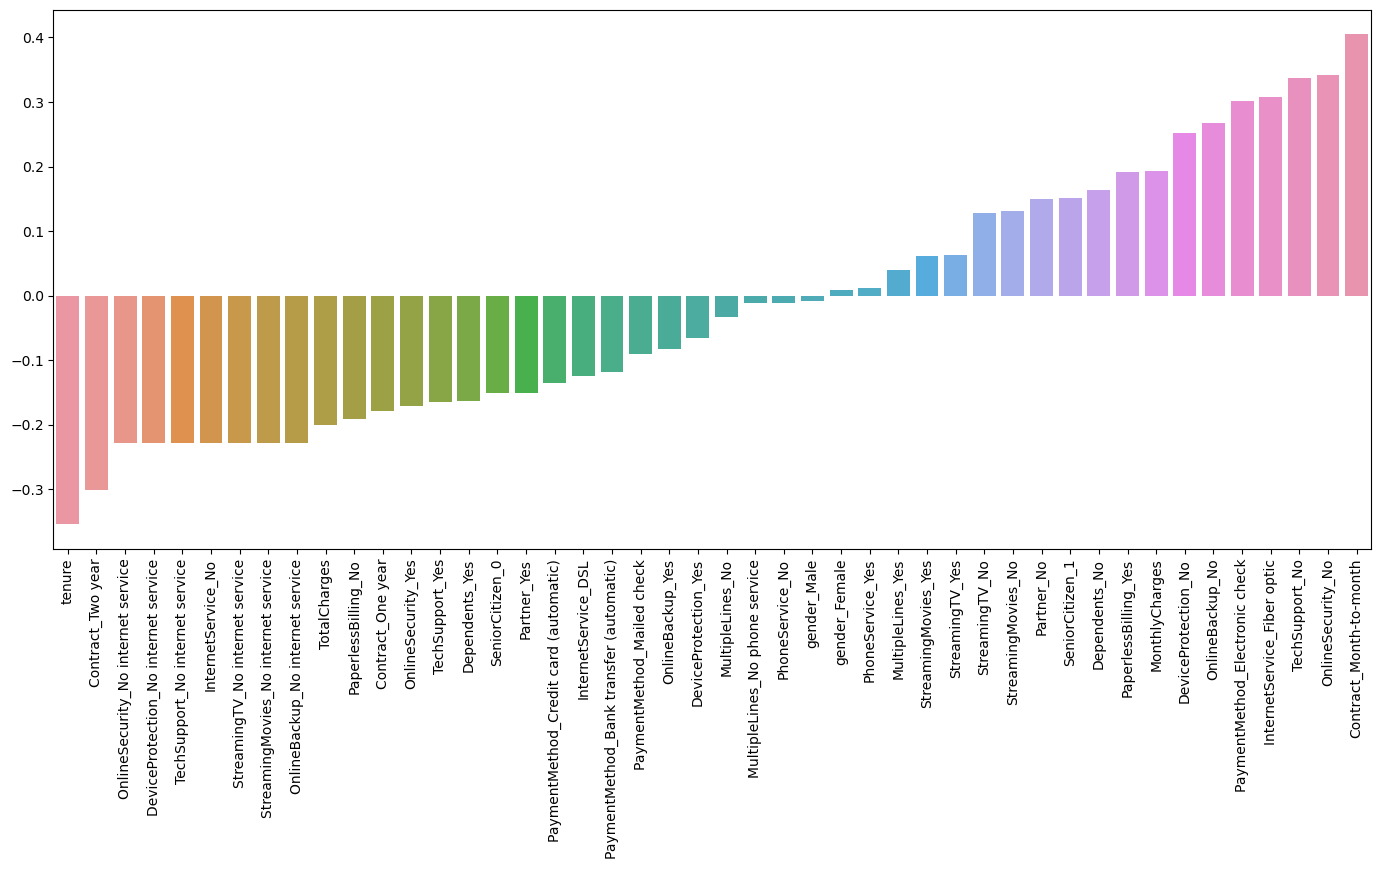

In [66]:
plt.figure(figsize=(17, 7))
sns.barplot(y=df_corr.values, x=df_corr.index)
plt.xticks(rotation=90);

---
---

# Часть 3: Анализ оттока

**Выполним сегментацию абонентов на основе колонки tenure, создавая "когорты" и выполняя сравнение данных между различными когортами.**

In [68]:
df['Contract'].unique()


array(['Month-to-month', 'One year', 'Two year'], dtype=object)

<AxesSubplot:xlabel='tenure', ylabel='Count'>

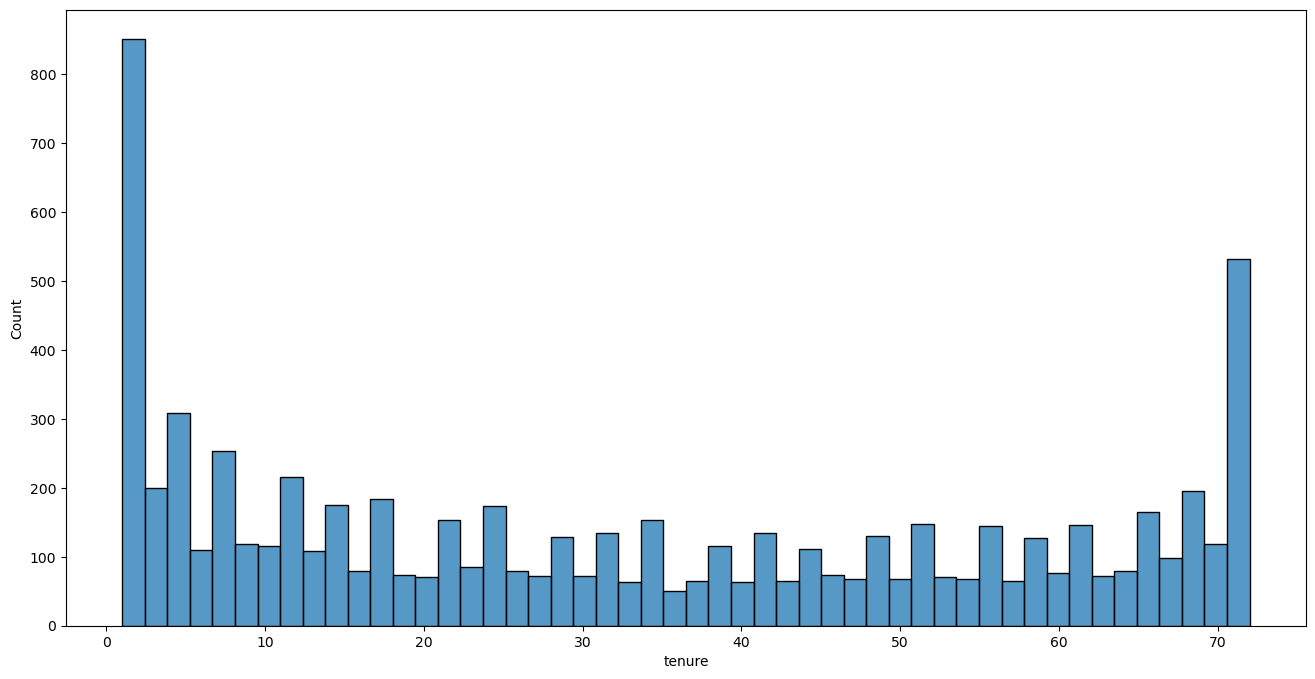

In [76]:
# Распределение колонки tenure (число месяцев, в течение которых человек является абонентом компании)
plt.figure(figsize=(16, 8))
sns.histplot(data=df, x='tenure', bins=50)


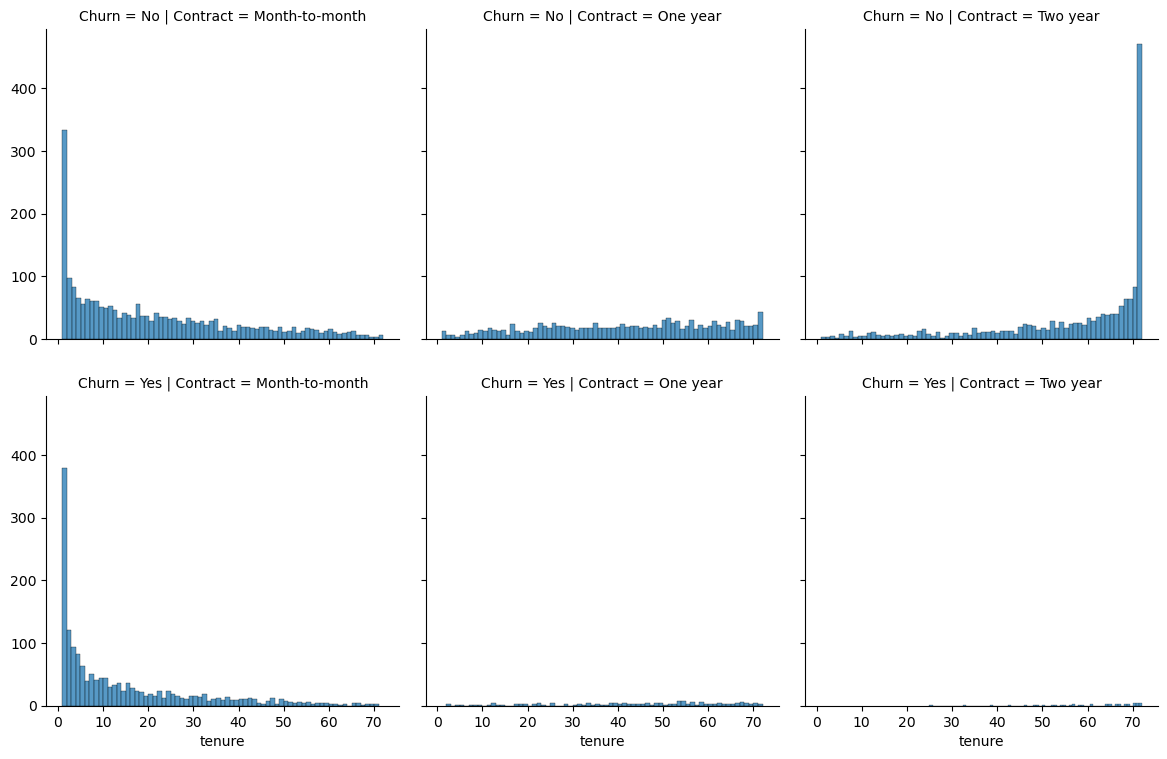

In [161]:
facet_grid = sns.FacetGrid(data=df, row="Churn", col="Contract")
facet_grid = facet_grid.map(sns.histplot, "tenure", bins=70)
facet_grid.fig.set_size_inches(12, 8) 


<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

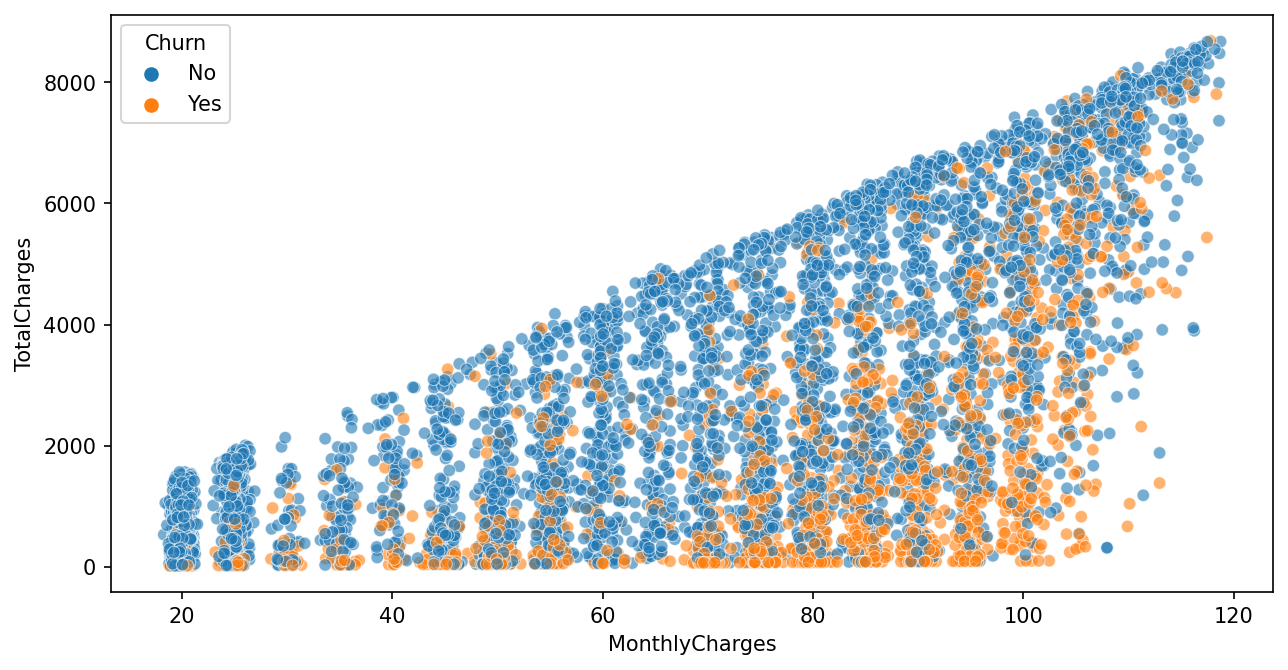

In [105]:
plt.figure(figsize=(10, 5), dpi=150)
sns.scatterplot(data=df, x="MonthlyCharges", y="TotalCharges", hue="Churn", alpha=0.6)


### Создание когорт (сегментов) по колонке Tenure

**Для начала поместим различные значения tenure (1 месяц, 2 месяца, 3 месяца и так далее) в отдельные когорты (сегменты).**


In [114]:
churn_rate = (df[df['Churn']=="Yes"].groupby(by="tenure").count() / 
              df.groupby(by="tenure").count() 
              * 100)['customerID']
churn_rate

tenure
1     61.990212
2     51.680672
3     47.000000
4     47.159091
5     48.120301
        ...    
68     9.000000
69     8.421053
70     9.243697
71     3.529412
72     1.657459
Name: customerID, Length: 72, dtype: float64

Text(0, 0.5, 'Churn Percentage')

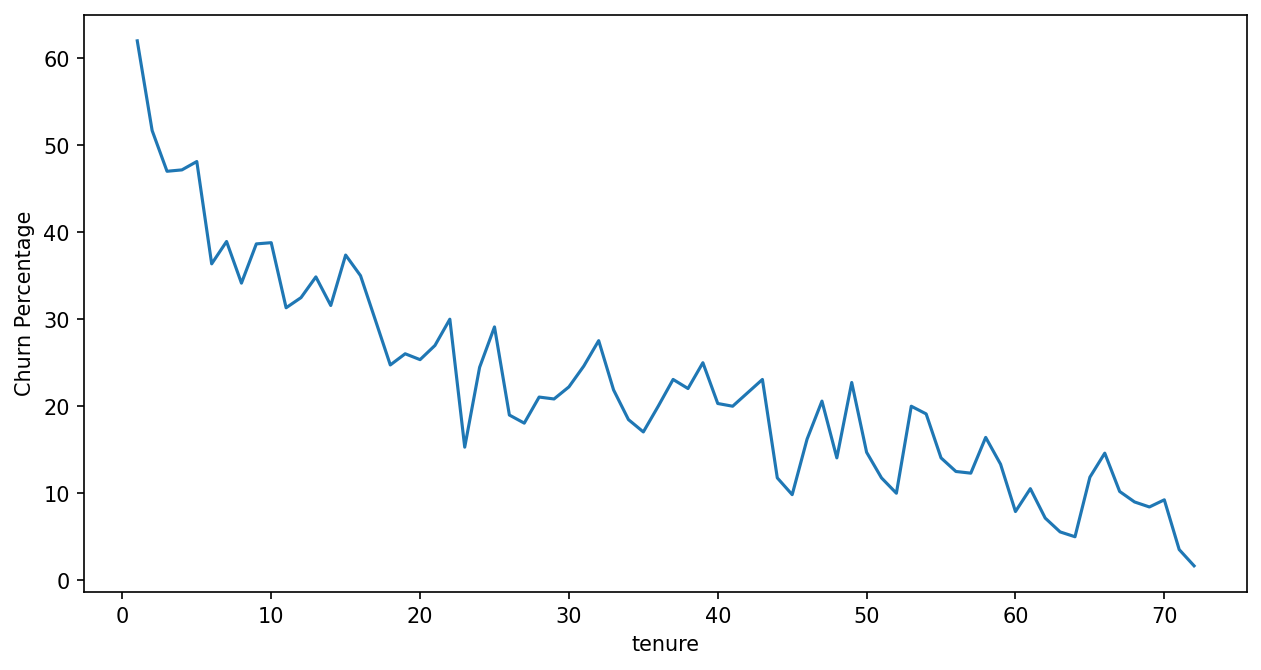

In [130]:
# График процента оттока для различных значений tenure
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(churn_rate.index, churn_rate.values)
plt.xlabel("tenure")
plt.ylabel("Churn Percentage")

### Более крупные когорты (сегменты)
**На основе колонки tenure создадим новую колонку с названием "Tenure Cohort", в которой будут следующие 4 категории:**
   * '0-12 месяцев'
   * '12-24 месяцев'
   * '24-48 месяцев'
   * 'Более 48 месяцев'    

In [145]:
def define_cohort(tenure):
    if tenure <= 12:
        return '0-12 Months'
    elif tenure <= 24:
        return '12-24 Months'
    elif tenure <= 48:
        return '24-48 Months'
    else:
        return 'Over 48 Months'
    
df["Tenure Cohort"] = df['tenure'].apply(define_cohort)


In [146]:
df[['tenure', 'Tenure Cohort']].head()

,tenure,Tenure Cohort
0,1,0-12 Months
1,34,24-48 Months
2,2,0-12 Months
3,45,24-48 Months
4,2,0-12 Months


**Задание: Постройте график scatterplot для Total Charges и Monthly Charges, раскрашивая график разными цветами по колонке "Tenure Cohort", которую Вы создали в предыдущем задании.**

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

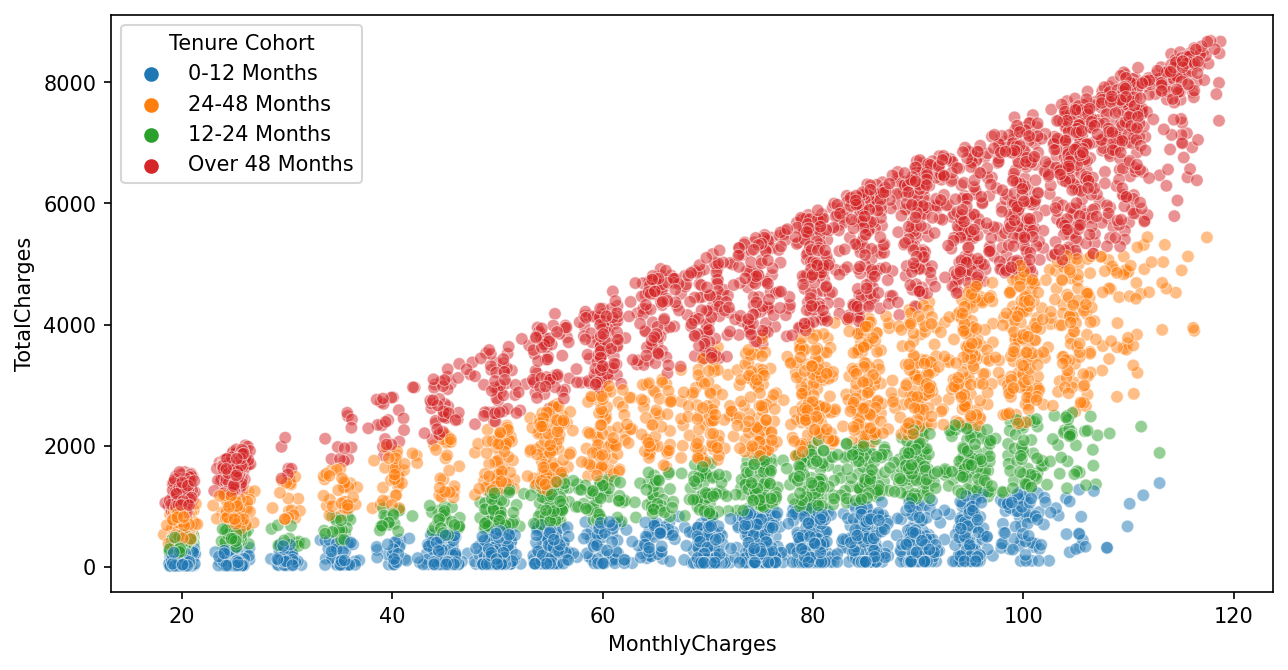

In [147]:
plt.figure(figsize=(10,5), dpi=150)
sns.scatterplot(data=df, x="MonthlyCharges", y="TotalCharges", hue="Tenure Cohort", alpha=0.5)


<AxesSubplot:xlabel='Tenure Cohort', ylabel='count'>

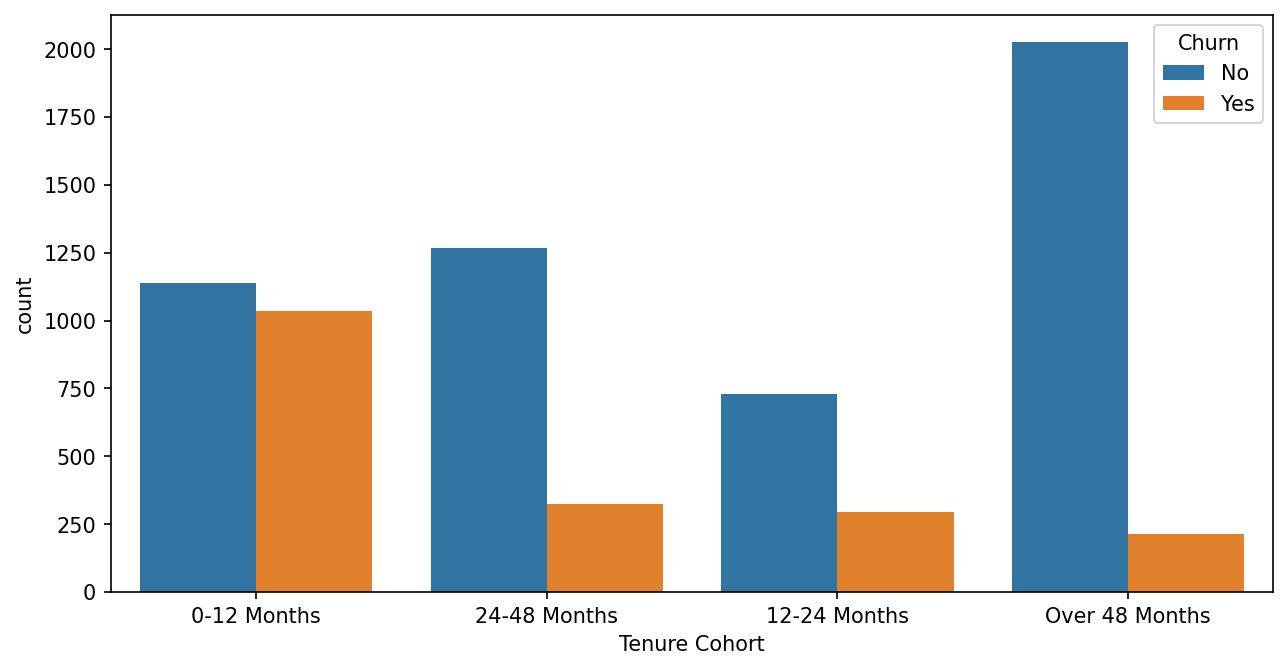

In [153]:
# Количество ушедших и не ушедших в отток людей в каждой когорте
plt.figure(figsize=(10, 5), dpi=150)
sns.countplot(data=df, x="Tenure Cohort", hue="Churn")

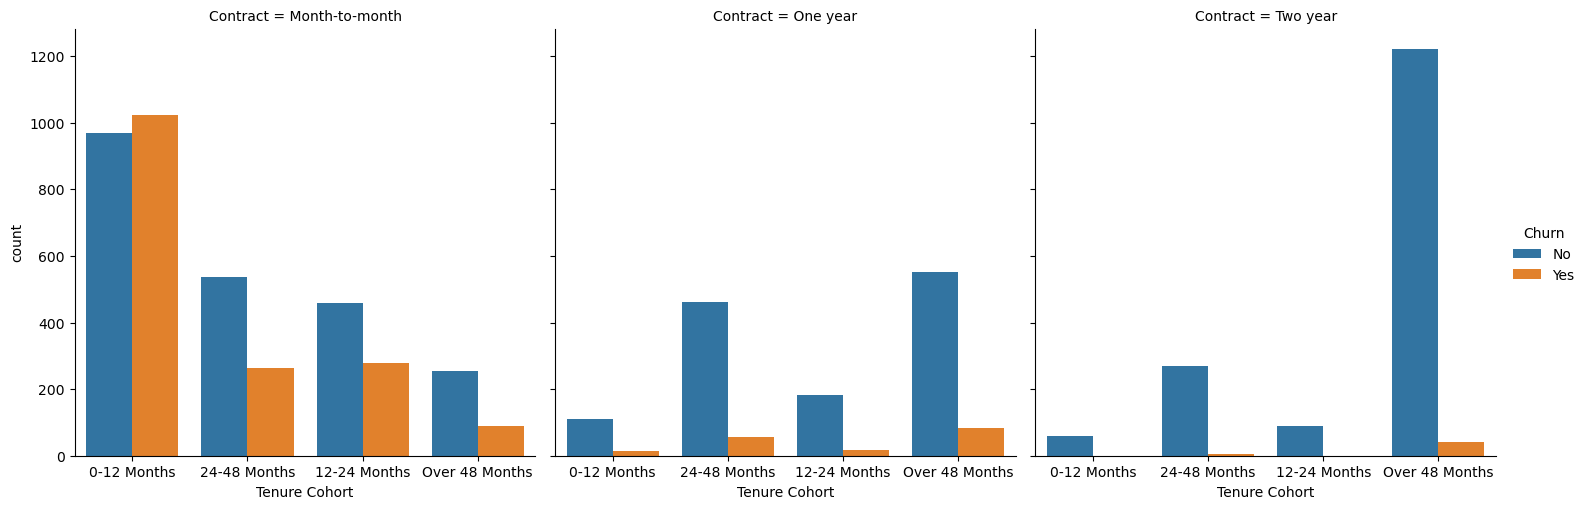

In [159]:
sns.catplot(data=df, x="Tenure Cohort", col="Contract", hue="Churn", kind="count")

-----

# Часть 4: Предиктивная модель

**Исследуем 4 модели на основе деревьев: одно дерево решений, случайный лес, адаптивный бустинг и градиентный бустинг.**


## Одно дерево решений (Decision Tree)

In [169]:
X = df.drop(["customerID", "Churn"], axis=1)
X = pd.get_dummies(X, drop_first=True)

In [170]:
y = df["Churn"]

In [171]:
from sklearn.model_selection import train_test_split

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=101)

In [196]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [ ]:
tree_grid_params = param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

In [177]:
tree = DecisionTreeClassifier()

In [178]:
tree_grid = GridSearchCV(tree, tree_grid_params)

In [179]:
tree_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, 15, 20, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15]})

In [180]:
tree_grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [182]:
y_pred = tree_grid.predict(X_test)

In [188]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.86      0.89      0.87       557
         Yes       0.52      0.44      0.47       147

    accuracy                           0.80       704
   macro avg       0.69      0.66      0.67       704
weighted avg       0.79      0.80      0.79       704



In [189]:
confusion_matrix(y_test, y_pred)

array([[497,  60],
       [ 83,  64]])

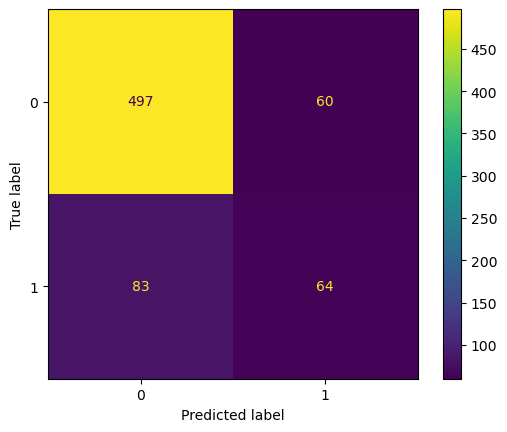

In [194]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

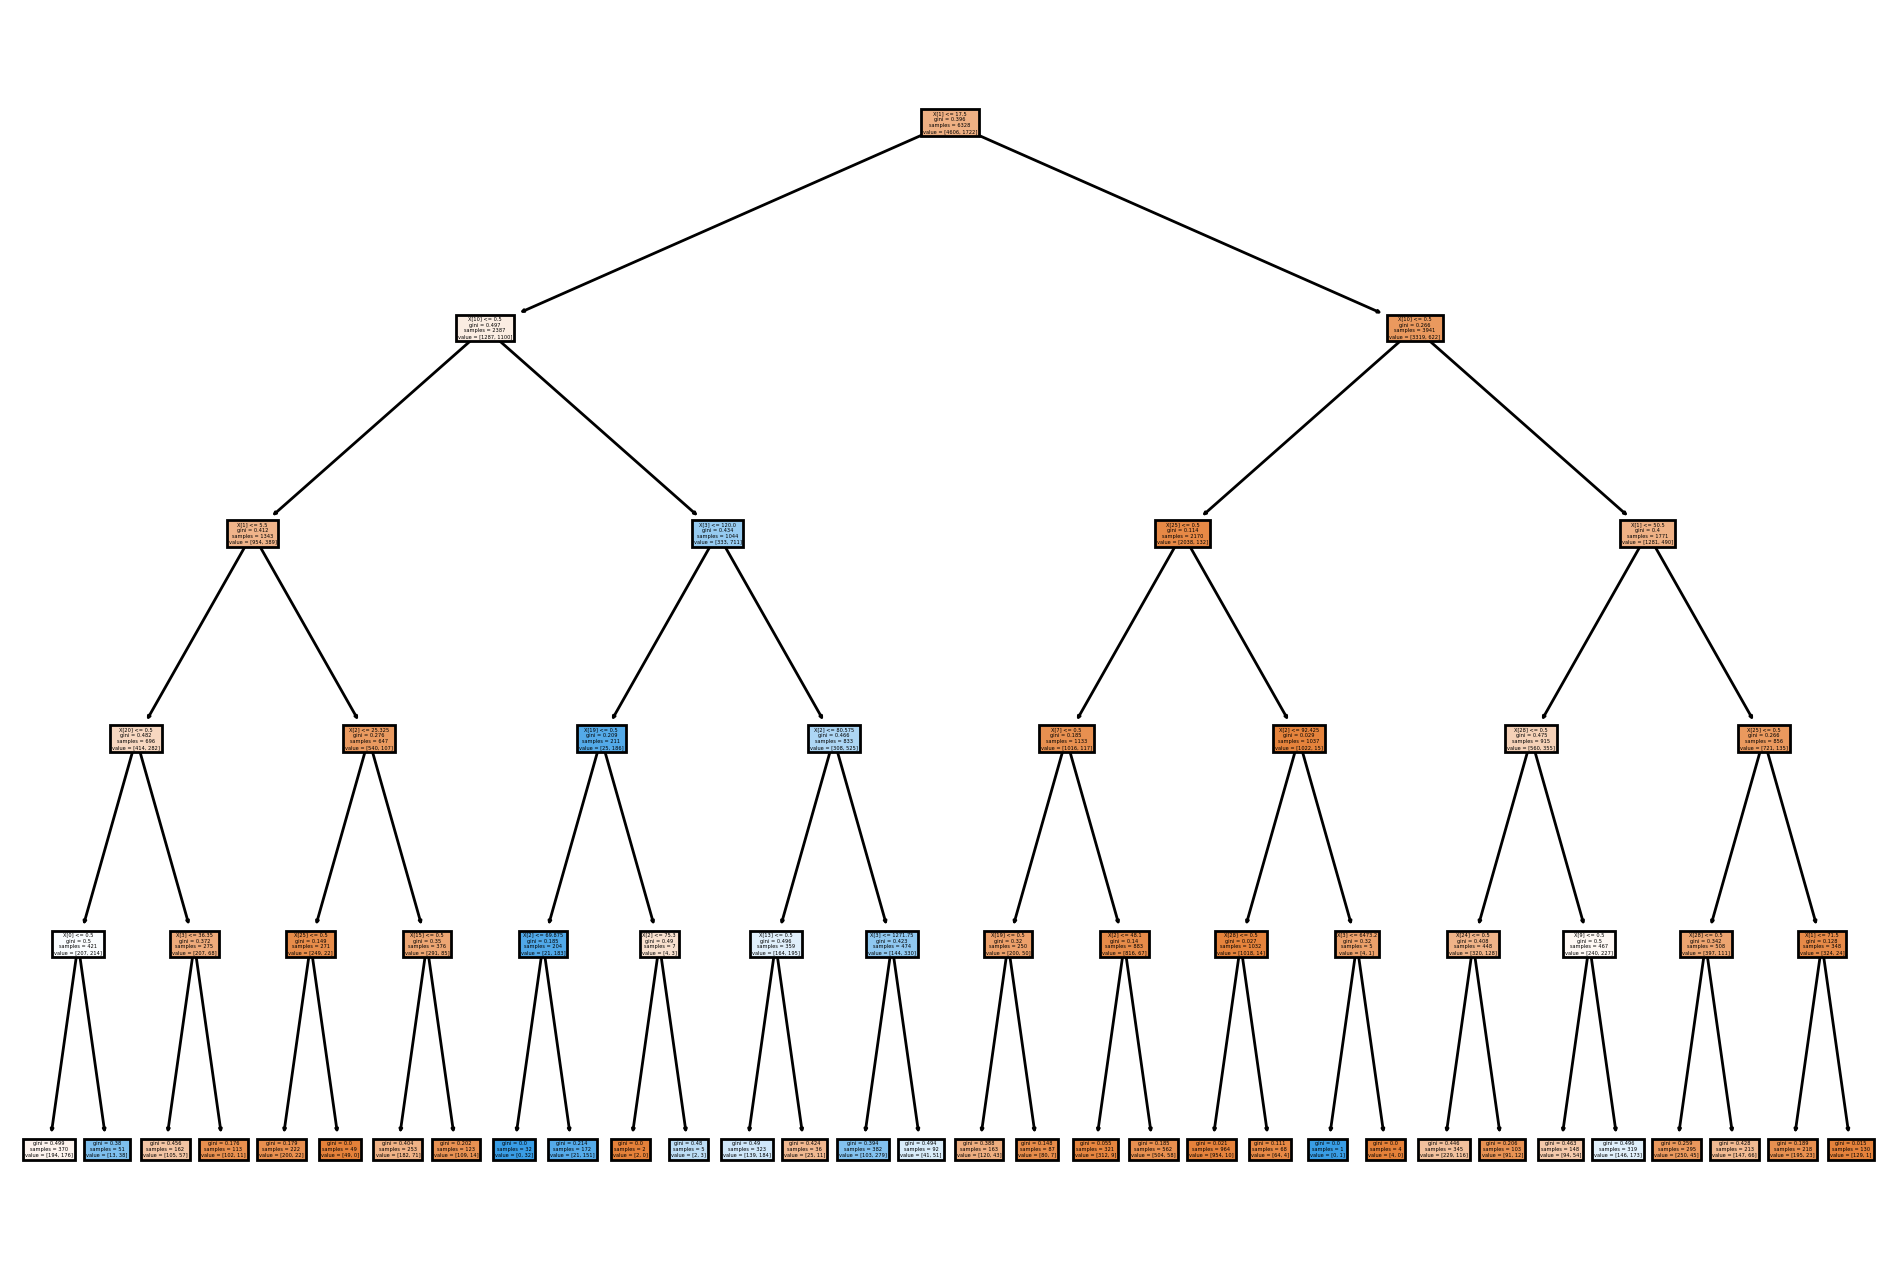

In [200]:
plt.figure(figsize=(12, 8), dpi=200)
plot_tree(tree_grid.best_estimator_, filled=True);

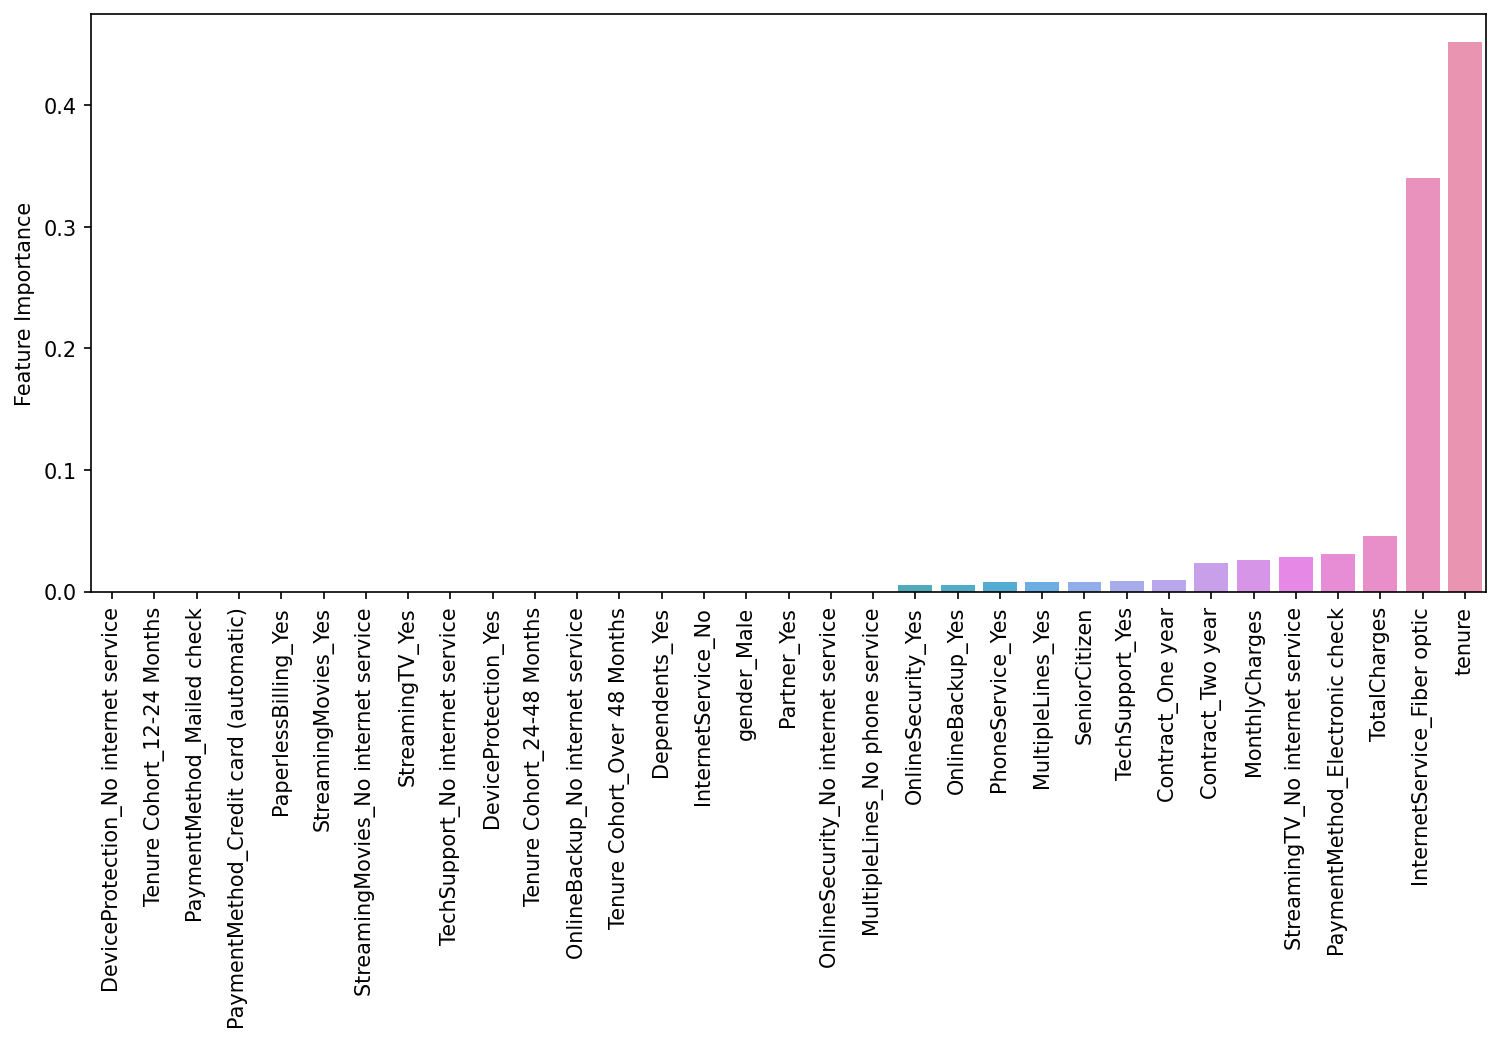

In [218]:
# Важаность признаков
feat_imp = pd.DataFrame(data=tree_grid.best_estimator_.feature_importances_,
             index=X.columns,
             columns=['Feature Importance']).sort_values(by='Feature Importance')

plt.figure(figsize=(12, 5), dpi=150)
sns.barplot(x=feat_imp.index, y=feat_imp["Feature Importance"])
plt.xticks(rotation=90);

## Случайный лес (Random Forest)

In [220]:
from sklearn.ensemble import RandomForestClassifier

In [221]:
random_forest = RandomForestClassifier()

In [225]:
random_forest_grid_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [226]:
random_forest_grid = GridSearchCV(random_forest, random_forest_grid_params)

In [227]:
random_forest_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [228]:
random_forest_grid.best_params_

{'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 50}

In [230]:
y_pred = random_forest_grid.predict(X_test)

In [231]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.87      0.91      0.89       557
         Yes       0.58      0.46      0.51       147

    accuracy                           0.82       704
   macro avg       0.72      0.69      0.70       704
weighted avg       0.80      0.82      0.81       704



In [232]:
confusion_matrix(y_test, y_pred)

array([[507,  50],
       [ 79,  68]])

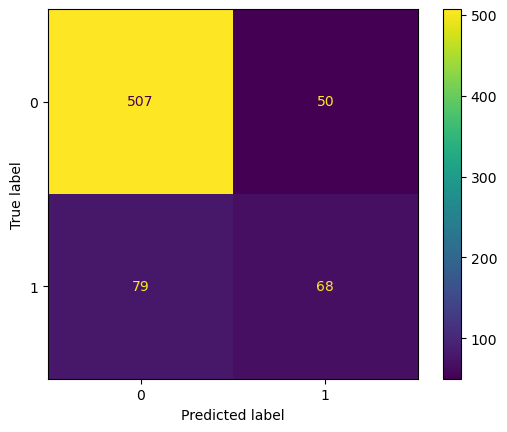

In [234]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

## Расширяемые деревья (Boosted Trees)

In [235]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [236]:
ada_boost = AdaBoostClassifier()

In [238]:
ada_boost_grid_params = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5]
}

In [239]:
ada_boost_grid = GridSearchCV(ada_boost, ada_boost_grid_params)

In [241]:
ada_boost_grid.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5],
                         'n_estimators': [50, 100, 200, 300]})

In [242]:
y_pred = ada_boost_grid.predict(X_test)

In [243]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.88      0.90      0.89       557
         Yes       0.60      0.54      0.57       147

    accuracy                           0.83       704
   macro avg       0.74      0.72      0.73       704
weighted avg       0.82      0.83      0.83       704



In [ ]:
confusion_matrix(y_test, y_pred)

array([[504,  67],
       [ 53,  80]])

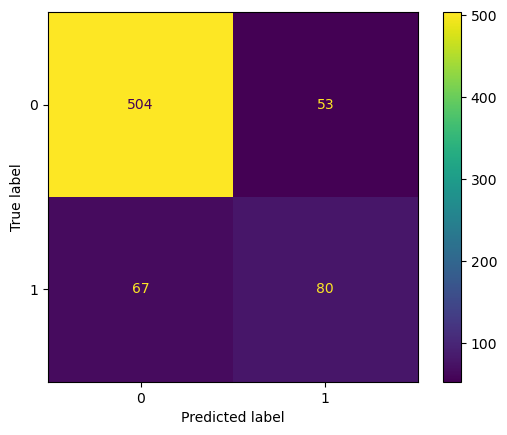

In [247]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [248]:
grad_boost = GradientBoostingClassifier()

In [252]:
grad_boost_grid_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9]
}

In [253]:
grad_boost_grid = GridSearchCV(grad_boost, grad_boost_grid_params)

In [254]:
grad_boost_grid.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 4],
                         'n_estimators': [100, 200], 'subsample': [0.8, 0.9]})

In [255]:
y_pred = ada_boost_grid.predict(X_test)

In [256]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.88      0.90      0.89       557
         Yes       0.60      0.54      0.57       147

    accuracy                           0.83       704
   macro avg       0.74      0.72      0.73       704
weighted avg       0.82      0.83      0.83       704



In [257]:
confusion_matrix(y_test, y_pred)

array([[504,  53],
       [ 67,  80]])

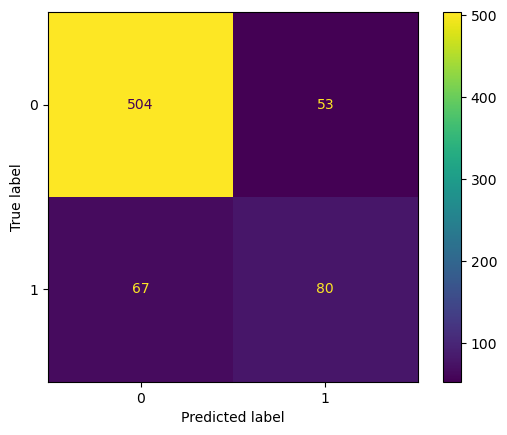

In [258]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

**Наилучшие результаты в моделях AdaBoostClassifier и GradientBoostingClassifier**